In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import mlflow
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Chargement des données
chemin_dossier = "C:/Users/paulm/Documents/Projet 7/Projet7withCSV/data/" 
df = pd.read_csv(os.path.join(chemin_dossier, 'processed_data.csv'))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307492 entries, 0 to 307510
Columns: 426 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_Yes
dtypes: float64(385), int64(41)
memory usage: 1001.7 MB


In [5]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_NaN,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_NaN,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.007466,0.005785,0.508408,0.005284,0.214757,0.210773,0.017437,0.473983,0.518446,0.007570
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.086085,0.075840,0.499930,0.072501,0.410654,0.407858,0.130892,0.499323,0.499660,0.086679
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
# Sélectionner uniquement les colonnes numériques
colonnes_numeriques = df.select_dtypes(include=[np.number])

# Identifier les colonnes contenant des valeurs infinies
colonnes_infinies = colonnes_numeriques.columns.to_series()[np.isinf(colonnes_numeriques).any()]

# Affichage des colonnes avec des valeurs infinies
print("Colonnes avec des valeurs infinies :")
print(colonnes_infinies)

# Identifier les lignes contenant des valeurs infinies
lignes_avec_infinis = df.index[np.isinf(colonnes_numeriques).any(axis=1)]

# Affichage des indices des lignes contenant des valeurs infinies
print("\nIndices des lignes avec des valeurs infinies :")
print(lignes_avec_infinis.tolist())

# Suppression des lignes contenant des valeurs infinies
df.drop(lignes_avec_infinis, inplace=True)

# Sélection des colonnes numériques après la suppression des lignes
colonnes_numeriques = df.select_dtypes(include=[np.number])

# Vérification
print("\nReste-t-il des valeurs infinies ?")
reste_infinis = np.isinf(colonnes_numeriques).any().any()
print(reste_infinis)

# Si des valeurs infinies restent, les remplacer par NaN
if reste_infinis:
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    print("\nLes valeurs infinies ont été remplacées par NaN.")

# Vérification
reste_infinis = np.isinf(colonnes_numeriques).any().any()
print("\nReste-t-il des valeurs infinies après remplacement ?")
print(reste_infinis)

Colonnes avec des valeurs infinies :
PREV_APP_CREDIT_PERC_MAX      PREV_APP_CREDIT_PERC_MAX
PREV_APP_CREDIT_PERC_MEAN    PREV_APP_CREDIT_PERC_MEAN
INSTAL_PAYMENT_PERC_MEAN      INSTAL_PAYMENT_PERC_MEAN
INSTAL_PAYMENT_PERC_SUM        INSTAL_PAYMENT_PERC_SUM
dtype: object

Indices des lignes avec des valeurs infinies :
[5687, 60477, 79077, 89018, 98509, 126768, 128791, 140426, 152087, 167136, 199103, 201086, 236164, 238381, 272829, 277962, 287300, 292852, 305373]

Reste-t-il des valeurs infinies ?
False

Reste-t-il des valeurs infinies après remplacement ?
False


In [6]:
# Adresse de MLflow
mlflow_url = "http://127.0.0.1:5000"

# Coût d'un faux positif et d'un faux négatif
cost_fp = 1  
cost_fn = 10  

# Conserver la colonne d'identifiant unique
id_column = 'SK_ID_CURR'
df_id = df[[id_column]]  # Conserver les identifiants

# Gestion des valeurs manquantes avec SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(df.drop(columns=['TARGET'])), columns=df.drop(columns=['TARGET']).columns)

# Enregistrer X dans un fichier CSV pour l'utilisation dans l'API Flask
X_to_save = X.copy()
X_to_save['SK_ID_CURR'] = df_id['SK_ID_CURR'].values
# Utilisation de la méthode reindex pour réorganiser les colonnes
columns = ['SK_ID_CURR'] + [col for col in X_to_save.columns if col != 'SK_ID_CURR']
X_to_save = X_to_save[columns]
# Enregistrez le DataFrame dans un fichier CSV
X_to_save.to_csv('X_predictionV0.csv', index=False)

# Séparation des caractéristiques et la cible
y = df['TARGET']

# Séparation des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_to_save, y, test_size=0.2, random_state=42)

# Définir le modèle XGBoost avec ses paramètres
model = XGBClassifier(scale_pos_weight=10, random_state=42)  
params = {'n_estimators': [50, 100], 'max_depth': [3, 6, 9]}  

# Configurer l'expérience MLflow
mlflow.set_tracking_uri(mlflow_url)
mlflow.set_experiment("Credit Scoring Experiment")

# Échantillonner les données
sample_size = 0.1 
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=(1 - sample_size), random_state=42)
X_test_sample, _, y_test_sample, _ = train_test_split(X_test, y_test, test_size=(1 - sample_size), random_state=42)

# Entraînement du modèle XGBoost obtention des meilleurs paramètres
with mlflow.start_run(run_name="XGBoost"):
    print("Entraînement du modèle XGBoost...")

    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='f1', cv=3)
    grid_search.fit(X_train_sample, y_train_sample)

    # Loguer les paramètres dans MLflow
    mlflow.log_params(grid_search.best_params_)

    # Affichage des meilleurs paramètres et le score F1
    print(f"Meilleurs paramètres pour XGBoost: {grid_search.best_params_}")
    print(f"Score F1 moyen sur le jeu de validation: {grid_search.best_score_:.3f}")

    # Utilisation du meilleur modèle pour les prédictions
    best_model = grid_search.best_estimator_
    y_prob = best_model.predict_proba(X_test_sample)[:, 1]

    # Évaluation du modèle avec le meilleur seuil pour minimiser le coût métier
    thresholds = np.linspace(0, 1, 100)
    costs = []
    for threshold in thresholds:
        y_pred_thresholded = (y_prob > threshold).astype(int)
        fp = np.sum((y_pred_thresholded == 1) & (y_test_sample == 0)) * cost_fp
        fn = np.sum((y_pred_thresholded == 0) & (y_test_sample == 1)) * cost_fn
        total_cost = fp + fn
        costs.append(total_cost)

    best_threshold = thresholds[np.argmin(costs)]
    print(f"Meilleur seuil pour minimiser le coût métier avec XGBoost: {best_threshold}")

    y_pred_best_threshold = (y_prob > best_threshold).astype(int)

    # Calcul du score AUC-ROC
    auc_roc = roc_auc_score(y_test_sample, y_prob)
    print(f"AUC-ROC pour le modèle XGBoost: {auc_roc:.3f}")

    # Affichage du rapport de classification et de la matrice de confusion
    classification_report_str = classification_report(y_test_sample, y_pred_best_threshold)
    confusion_matrix_str = confusion_matrix(y_test_sample, y_pred_best_threshold)

    print(f"Rapport de classification avec le meilleur seuil pour XGBoost:")
    print(classification_report_str)

    print(f"Matrice de confusion avec le meilleur seuil pour XGBoost:")
    print(confusion_matrix_str)
    print()

    # Loguer les métriques et les résultats dans MLflow
    mlflow.log_metric("best_score_f1", grid_search.best_score_)
    mlflow.log_metric("best_threshold", best_threshold)
    mlflow.log_metric("auc_roc", auc_roc)  # Loguer l'AUC-ROC
    mlflow.log_text(classification_report_str, "classification_report.txt")
    mlflow.log_text(str(confusion_matrix_str), "confusion_matrix.txt")

    # Loguer le modèle
    model_path = 'model/xgboost_model.pkl'
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    mlflow.sklearn.log_model(best_model, "model")

    # Sauvegarder le modèle dans un fichier .pkl
    joblib.dump(best_model, model_path)

Entraînement du modèle XGBoost...
Meilleurs paramètres pour XGBoost: {'max_depth': 3, 'n_estimators': 50}
Score F1 moyen sur le jeu de validation: 0.287
Meilleur seuil pour minimiser le coût métier avec XGBoost: 0.494949494949495
AUC-ROC pour le modèle XGBoost: 0.768
Rapport de classification avec le meilleur seuil pour XGBoost:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      5663
           1       0.19      0.64      0.29       486

    accuracy                           0.75      6149
   macro avg       0.57      0.70      0.57      6149
weighted avg       0.90      0.75      0.80      6149

Matrice de confusion avec le meilleur seuil pour XGBoost:
[[4308 1355]
 [ 177  309]]



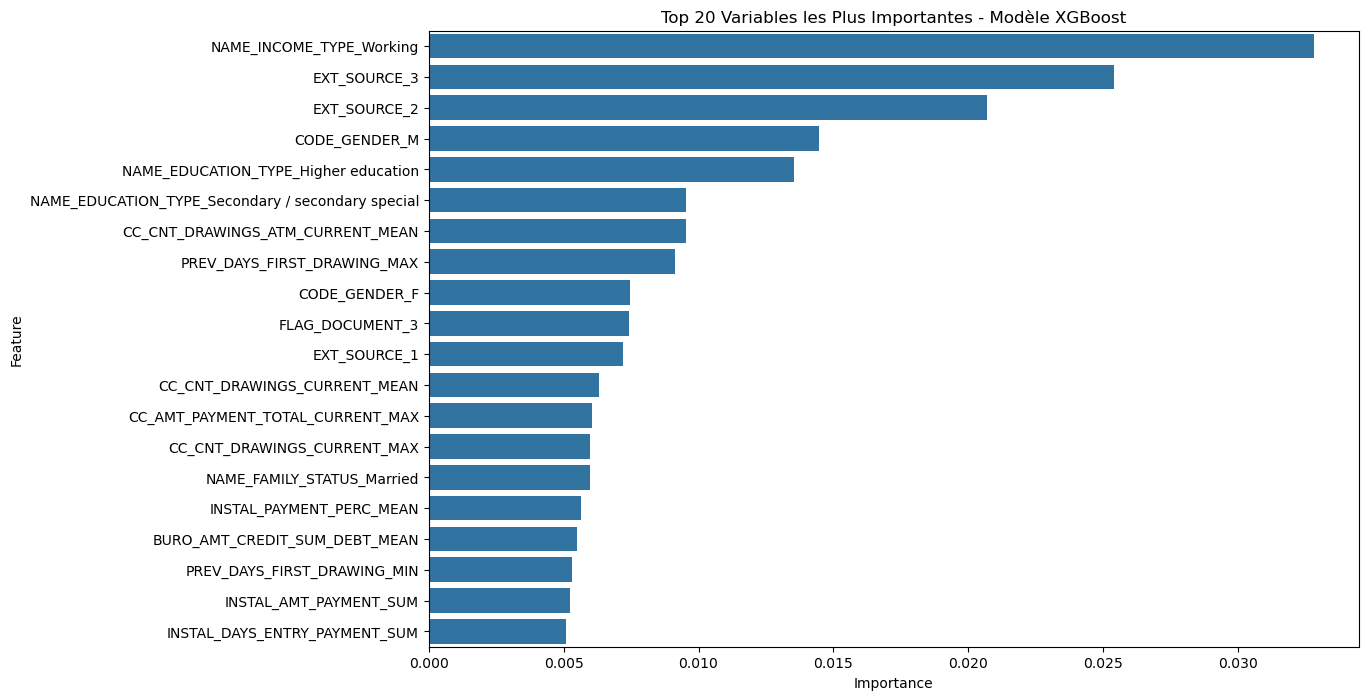

In [8]:
import seaborn as sns

# Entraînement du modèle XGBoost (avec les meilleurs hyperparamètres trouvés)
model = XGBClassifier(scale_pos_weight=10, random_state=42)  
model.fit(X_train, y_train)

# Extraire l'importance des variables
importance = model.feature_importances_

# Créer un DataFrame pour faciliter la visualisation
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Sélectionner les 20 variables les plus importantes
top_20_importance_df = importance_df.head(20)

# Visualiser l'importance des variables
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_importance_df)
plt.title('Top 20 Variables les Plus Importantes - Modèle XGBoost')
plt.show()

Et maintenant avec une validation croisé plus poussée : 

In [32]:
# Définir la grille de paramètres plus ciblée
params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0, 0.01],
    'reg_lambda': [1, 3]
}

# Entraînement du modèle XGBoost avec RandomizedSearchCV
grid_search = RandomizedSearchCV(estimator=model, param_distributions=params, scoring='f1', cv=3, n_iter=30, random_state=42)
grid_search.fit(X_train_sample, y_train_sample)

# Loguer les meilleurs paramètres et score
best_model = grid_search.best_estimator_
print(f"Meilleurs paramètres pour XGBoost: {grid_search.best_params_}")
print(f"Score F1 moyen sur le jeu de validation: {grid_search.best_score_:.3f}")

# Prédictions et évaluation
y_prob = best_model.predict_proba(X_test_sample)[:, 1]
y_pred = best_model.predict(X_test_sample)

# Calcul du meilleur seuil pour minimiser le coût métier
thresholds = np.linspace(0, 1, 100)
costs = []
for threshold in thresholds:
    y_pred_thresholded = (y_prob > threshold).astype(int)
    fp = np.sum((y_pred_thresholded == 1) & (y_test_sample == 0)) * cost_fp
    fn = np.sum((y_pred_thresholded == 0) & (y_test_sample == 1)) * cost_fn
    total_cost = fp + fn
    costs.append(total_cost)

best_threshold = thresholds[np.argmin(costs)]
print(f"Meilleur seuil pour minimiser le coût métier avec XGBoost: {best_threshold}")

y_pred_best_threshold = (y_prob > best_threshold).astype(int)

# Calcul du score AUC-ROC
auc_roc = roc_auc_score(y_test_sample, y_prob)
print(f"AUC-ROC pour le modèle XGBoost: {auc_roc:.3f}")

# Rapport de classification et matrice de confusion
classification_report_str = classification_report(y_test_sample, y_pred_best_threshold)
confusion_matrix_str = confusion_matrix(y_test_sample, y_pred_best_threshold)

print(f"Rapport de classification avec le meilleur seuil pour XGBoost:")
print(classification_report_str)

print(f"Matrice de confusion avec le meilleur seuil pour XGBoost:")
print(confusion_matrix_str)

# Loguer les métriques et le modèle dans MLflow
mlflow.log_metric("best_score_f1", grid_search.best_score_)
mlflow.log_metric("best_threshold", best_threshold)
mlflow.log_metric("auc_roc", auc_roc)
mlflow.log_text(classification_report_str, "classification_report.txt")
mlflow.log_text(str(confusion_matrix_str), "confusion_matrix.txt")

model_path = 'model/xgboost_model_optimized.pkl'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
mlflow.sklearn.log_model(best_model, "model")

# Sauvegarder le modèle dans un fichier .pkl
joblib.dump(best_model, model_path)

Meilleurs paramètres pour XGBoost: {'subsample': 0.7, 'reg_lambda': 3, 'reg_alpha': 0, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.7}
Score F1 moyen sur le jeu de validation: 0.120
Meilleur seuil pour minimiser le coût métier avec XGBoost: 0.08080808080808081
AUC-ROC pour le modèle XGBoost: 0.738
Rapport de classification avec le meilleur seuil pour XGBoost:
              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83      5663
         1.0       0.17      0.63      0.27       486

    accuracy                           0.72      6149
   macro avg       0.56      0.68      0.55      6149
weighted avg       0.90      0.72      0.79      6149

Matrice de confusion avec le meilleur seuil pour XGBoost:
[[4146 1517]
 [ 180  306]]


['model/xgboost_model_optimized.pkl']

In [ ]:
# Adresse de MLflow
mlflow_url = "http://127.0.0.1:5000"

# Configurer l'expérience MLflow
mlflow.set_tracking_uri(mlflow_url)
mlflow.set_experiment("Credit Scoring Experiment")

# Définition du modèle XGBoost et des paramètres à optimiser
model = XGBClassifier()
params = {
    'n_estimators': [50, 100, 200, 250],
    'max_depth': [3, 6, 9, 11],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Entraînement du modèle XGBoost avec validation croisée
with mlflow.start_run(run_name="XGBoost with Cross-Validation"):
    print("Entraînement du modèle XGBoost avec validation croisée...")

    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='f1', cv=3)
    
    # Entraînement avec GridSearchCV et suivi MLflow
    grid_search.fit(X_train_sample, y_train_sample)

    # Loguer les meilleurs paramètres dans MLflow
    mlflow.log_params(grid_search.best_params_)

    # Affichage des meilleurs paramètres et le score F1
    print(f"Meilleurs paramètres pour XGBoost: {grid_search.best_params_}")
    print(f"Score F1 moyen sur le jeu de validation: {grid_search.best_score_:.3f}")

    # Utilisation du meilleur modèle pour les prédictions
    best_model = grid_search.best_estimator_
    
    # Prédictions avec validation croisée pour obtenir les prédictions stables
    y_pred = cross_val_predict(best_model, X_test_sample, y_test_sample, cv=3)

    # Évaluation du modèle avec le meilleur seuil pour minimiser le coût métier
    y_prob = best_model.predict_proba(X_test_sample)[:, 1]
    thresholds = np.linspace(0, 1, 100)
    costs = []
    for threshold in thresholds:
        y_pred_thresholded = (y_prob > threshold).astype(int)
        fp = np.sum((y_pred_thresholded == 1) & (y_test_sample == 0)) * cost_fp
        fn = np.sum((y_pred_thresholded == 0) & (y_test_sample == 1)) * cost_fn
        total_cost = fp + fn
        costs.append(total_cost)

    best_threshold = thresholds[np.argmin(costs)]
    print(f"Meilleur seuil pour minimiser le coût métier avec XGBoost: {best_threshold}")

    y_pred_best_threshold = (y_prob > best_threshold).astype(int)

    # Affichage du rapport de classification et de la matrice de confusion
    classification_report_str = classification_report(y_test_sample, y_pred_best_threshold)
    confusion_matrix_str = confusion_matrix(y_test_sample, y_pred_best_threshold)

    print(f"Rapport de classification avec le meilleur seuil pour XGBoost:")
    print(classification_report_str)

    print(f"Matrice de confusion avec le meilleur seuil pour XGBoost:")
    print(confusion_matrix_str)
    print()

    # Loguer les métriques et les résultats dans MLflow
    mlflow.log_metric("best_score_f1", grid_search.best_score_)
    mlflow.log_metric("best_threshold", best_threshold)
    mlflow.log_text(classification_report_str, "classification_report.txt")
    mlflow.log_text(str(confusion_matrix_str), "confusion_matrix.txt")

    # Loguer le modèle
    model_path = 'model/xgboost_model_cv.pkl'
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    mlflow.sklearn.log_model(best_model, "model")

    # Sauvegarder le modèle dans un fichier .pkl
    joblib.dump(best_model, model_path)

Entraînement du modèle XGBoost avec validation croisée...
Meilleurs paramètres pour XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
Score F1 moyen sur le jeu de validation: 0.066
Meilleur seuil pour minimiser le coût métier avec XGBoost: 0.11111111111111112
Rapport de classification avec le meilleur seuil pour XGBoost:
              precision    recall  f1-score   support

         0.0       0.96      0.80      0.87      5663
         1.0       0.20      0.59      0.30       486

    accuracy                           0.78      6149
   macro avg       0.58      0.70      0.59      6149
weighted avg       0.90      0.78      0.83      6149

Matrice de confusion avec le meilleur seuil pour XGBoost:
[[4540 1123]
 [ 200  286]]



En résumé, l'utilisation de la validation croisée a permis d'obtenir des paramètres optimisés pour le modèle XGBoost. Les résultats montrent une légère amélioration du rappel et du score F1 pour la classe 1 (classe minoritaire), ainsi qu'une précision globale et une matrice de confusion plus équilibrées. La validation croisée semble donc offrir une meilleure généralisation des performances du modèle, notamment pour la classe minoritaire, ce qui est crucial pour le problème de scoring de crédit.

### Extraction des caractéristiques importantes :

In [ ]:
# Meilleur modèle sélectionné après l'entraînement et l'optimisation
best_model = grid_search.best_estimator_

# Extraire l'importance des caractéristiques
importances = best_model.feature_importances_

# Récupérer le nom des colonnes d'entraînement
feature_names = X_train_sample.columns

# Créer un DataFrame pour mieux visualiser les importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Trier par ordre décroissant d'importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Afficher les 10 caractéristiques les plus importantes
top_10_features = feature_importance_df.head(12)
print("Top 10 des caractéristiques importantes :")
print(top_10_features)

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 des Caractéristiques Importantes')
plt.gca().invert_yaxis()
plt.show()

Voici la description de chaque caractéristique parmi les plus importantes :

EXT_SOURCE_3

Description : C'est une des sources de notation de crédit externes, souvent provenant de bureaux de crédit ou d'autres agences d'évaluation. La valeur indique une estimation de la probabilité de défaut de l'emprunteur par une source externe. La source spécifique peut varier mais généralement, les valeurs plus élevées indiquent un risque de crédit plus faible.

EXT_SOURCE_2
Description : Similaire à EXT_SOURCE_3, c'est une autre source externe de notation de crédit. Elle fournit une évaluation externe de la probabilité de défaut de l'emprunteur. Comme pour EXT_SOURCE_3, les valeurs plus élevées indiquent un risque de crédit plus faible.

FLAG_EMP_PHONE
Description : Indique si l'emprunteur a fourni un numéro de téléphone professionnel. C'est une variable binaire où 1 signifie que l'emprunteur a fourni un numéro de téléphone professionnel et 0 signifie qu'il ne l'a pas fait.

CC_CNT_DRAWINGS_CURRENT_MEAN
Description : C'est la moyenne des dessins (retraits) courants sur la carte de crédit de l'emprunteur. Cela donne une idée de la fréquence et du montant des retraits effectués par l'emprunteur sur sa carte de crédit.

CC_AMT_RECEIVABLE_PRINCIPAL_MEAN
Description : C'est la moyenne des montants recevables principaux (le principal restant dû) sur la carte de crédit de l'emprunteur. Cela indique combien l'emprunteur doit encore payer sur le principal de ses dettes de carte de crédit.

NAME_EDUCATION_TYPE
Description : C'est le niveau d'éducation de l'emprunteur. Les catégories peuvent inclure "Secondaire / secondaire spécial", "Enseignement supérieur", "Enseignement professionnel", etc. Ce type de donnée est généralement encodé numériquement pour être utilisé dans les modèles de machine learning.

CC_MONTHS_BALANCE_SIZE
Description : Cela représente la taille de l'historique des soldes mensuels des cartes de crédit de l'emprunteur. En d'autres termes, combien de mois de données de solde de carte de crédit sont disponibles pour l'emprunteur.

CC_AMT_BALANCE_MEAN
Description : C'est la moyenne des soldes des cartes de crédit de l'emprunteur. Cela donne une idée de combien l'emprunteur a en moyenne comme solde sur ses cartes de crédit.

PREV_NAME_YIELD_GROUP_low_action_MEAN
Description : Cela représente la moyenne des précédents groupes de rendement (yield groups) catégorisés comme "low_action". Ces groupes de rendement sont utilisés pour classer les précédents prêts de l'emprunteur en fonction de leur performance financière (par exemple, rendement élevé, rendement faible, etc.).

PREV_DAYS_FIRST_DRAWING_MIN
Description : C'est le nombre minimum de jours jusqu'au premier retrait sur les précédents prêts de l'emprunteur. Cela indique combien de jours se sont écoulés avant que l'emprunteur effectue le premier retrait sur ses précédents prêts.

CC_CNT_DRAWINGS_CURRENT_MAX
Type: float64
Exemple de valeur: 0.005005
Description: Valeur maximale du nombre de dessins actuels sur les cartes de crédit. Cette variable représente la valeur maximale observée pour le nombre de transactions de dessin sur les cartes de crédit.

BURO_CREDIT_ACTIVE_Closed_MEAN
Type: float64
Exemple de valeur: 0.004893
Description: Moyenne de l'état des crédits passés où l'état est "Fermé". Cette variable représente la proportion moyenne des crédits passés qui sont maintenant fermés.

In [ ]:
# Chargement des données
chemin_dossier = "C:/Users/paulm/Documents/Projet 7/Projet7withCSV/data/" 
data = pd.read_csv(os.path.join(chemin_dossier, 'processed_data_encoded.csv'))

# Sélectionner les colonnes importantes
important_features = [
    'EXT_SOURCE_3',
    'EXT_SOURCE_2',
    'FLAG_EMP_PHONE',
    'CC_CNT_DRAWINGS_CURRENT_MEAN',
    'CC_AMT_RECEIVABLE_PRINCIPAL_MEAN',
    'NAME_EDUCATION_TYPE',
    'CC_MONTHS_BALANCE_SIZE',
    'CC_AMT_BALANCE_MEAN',
    'PREV_NAME_YIELD_GROUP_low_action_MEAN',
    'PREV_DAYS_FIRST_DRAWING_MIN'
]

# Filtrer les données pour n'afficher que les colonnes importantes
important_data = data[important_features]

# Afficher un aperçu des données
print(important_data.head())

# Afficher des statistiques descriptives pour chaque colonne
print(important_data.describe())

# Afficher les types de données pour chaque colonne
print(important_data.dtypes)


#### Visualisation et tests de l'influence des caractéristiques importantes :

In [ ]:
# Définir le modèle XGBoost
model = XGBClassifier(scale_pos_weight=10, random_state=42)

# Entraînement du modèle avec toutes les caractéristiques
model.fit(X_train, y_train)

# Extraire l'importance des caractéristiques
importances = model.feature_importances_

# Créer un DataFrame pour l'importance des caractéristiques
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Trier les caractéristiques par importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Sélectionner les 50 caractéristiques les plus importantes
num_features_to_keep = 50
important_features = feature_importances.head(num_features_to_keep)['feature']

# Réduire X_train et X_test aux caractéristiques sélectionnées
X_train_reduced = X_train[important_features]
X_test_reduced = X_test[important_features]

Configuration de MLflow et de la validation croisée :

In [ ]:
# Configuration de la validation croisée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Définir les paramètres de la recherche de grille
params = {'n_estimators': [50, 100], 'max_depth': [3, 6, 9]}

Entraînement et validation du modèle XGBoost avec les caractéristiques réduites:

In [ ]:
# Définir le modèle XGBoost avec les caractéristiques réduites
model_reduced = XGBClassifier(scale_pos_weight=10, random_state=42)

# Effectuer la recherche de grille avec les données réduites
grid_search_reduced = GridSearchCV(estimator=model_reduced, param_grid=params, scoring='f1', cv=cv)
grid_search_reduced.fit(X_train_reduced, y_train)

# Loguer les paramètres dans MLflow
with mlflow.start_run(run_name="XGBoost Reduced Features"):
    print("Entraînement du modèle XGBoost avec caractéristiques réduites...")

    # Loguer les paramètres
    mlflow.log_params(grid_search_reduced.best_params_)

    # Affichage des meilleurs paramètres et le score F1
    print(f"Meilleurs paramètres pour XGBoost avec caractéristiques réduites: {grid_search_reduced.best_params_}")
    print(f"Score F1 moyen sur le jeu de validation: {grid_search_reduced.best_score_:.3f}")

    # Utilisation du meilleur modèle pour les prédictions
    best_model_reduced = grid_search_reduced.best_estimator_
    y_pred_reduced = best_model_reduced.predict(X_test_reduced)

    # Évaluation du modèle avec le meilleur seuil pour minimiser le coût métier
    y_prob_reduced = best_model_reduced.predict_proba(X_test_reduced)[:, 1]
    thresholds = np.linspace(0, 1, 100)
    costs = []
    for threshold in thresholds:
        y_pred_thresholded_reduced = (y_prob_reduced > threshold).astype(int)
        fp = np.sum((y_pred_thresholded_reduced == 1) & (y_test == 0)) * cost_fp
        fn = np.sum((y_pred_thresholded_reduced == 0) & (y_test == 1)) * cost_fn
        total_cost = fp + fn
        costs.append(total_cost)

    best_threshold_reduced = thresholds[np.argmin(costs)]
    print(f"Meilleur seuil pour minimiser le coût métier avec caractéristiques réduites: {best_threshold_reduced}")

    y_pred_best_threshold_reduced = (y_prob_reduced > best_threshold_reduced).astype(int)

    # Affichage du rapport de classification et de la matrice de confusion
    classification_report_str_reduced = classification_report(y_test, y_pred_best_threshold_reduced)
    confusion_matrix_str_reduced = confusion_matrix(y_test, y_pred_best_threshold_reduced)

    print(f"Rapport de classification avec le meilleur seuil pour XGBoost avec caractéristiques réduites:")
    print(classification_report_str_reduced)

    print(f"Matrice de confusion avec le meilleur seuil pour XGBoost avec caractéristiques réduites:")
    print(confusion_matrix_str_reduced)
    print()

    # Loguer les métriques et les résultats dans MLflow
    mlflow.log_metric("best_score_f1_reduced", grid_search_reduced.best_score_)
    mlflow.log_metric("best_threshold_reduced", best_threshold_reduced)
    mlflow.log_text(classification_report_str_reduced, "classification_report_reduced.txt")
    mlflow.log_text(str(confusion_matrix_str_reduced), "confusion_matrix_reduced.txt")

    # Loguer le modèle
    model_path_reduced = 'model/xgboost_model_reduced.pkl'
    os.makedirs(os.path.dirname(model_path_reduced), exist_ok=True)
    mlflow.sklearn.log_model(best_model_reduced, "model_reduced")

    # Sauvegarder le modèle dans un fichier .pkl
    joblib.dump(best_model_reduced, model_path_reduced)

En conclusion, mon approche de réduction de caractéristiques semble ne pas être bénéfique.